In [58]:
import kwant
import matplotlib.pyplot as plt
import numpy as np
from ccode.finite_system import finite_system
import scipy.sparse.linalg as sla
import ccode.tools as tl
from ccode.boundstate import find_boundstates, extract_boundstates
import time
import dask.bag as db
from dask_quantumtinkerer import Cluster, cluster_options
import itertools as it
from scipy.signal import find_peaks
%matplotlib inline
plt.rcParams.update({"font.size": 12})

In [2]:
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

### Cluster configuration

In [21]:
options = cluster_options()
options.worker_cores = 1  # you should always leave this to 1 (I think)
options.worker_memory = 2  # Need to atdjust this to meet your needs
options.extra_path = "/home/jtorresluna/work/trijunction_design/"  # Make sure to do this if you import any local modules!

In [22]:
cluster = Cluster(options)

In [23]:
cluster

In [24]:
print(
    "http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"
    + cluster.dashboard_link[17:]
)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/8359c40b25024c41a92bf6b82b92c206/status


In [25]:
client = cluster.get_client()

In [788]:
cluster.close()

In [9]:
params = tl.junction_parameters(m_nw=np.array([-2, 0, -2]), m_qd=-2, bx=0.011)
a = params['a']

# Trijunction

## Cavity states 

In [390]:
geometry = {
"A": 400*a**2,
"angle": np.pi/5,
"l": 0*a,
"w": 0*a,
"a": a,
"side": 'up',
"shape": 'triangle'
}

In [391]:
cavity, f_params = finite_system(**geometry)
cavity = cavity.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


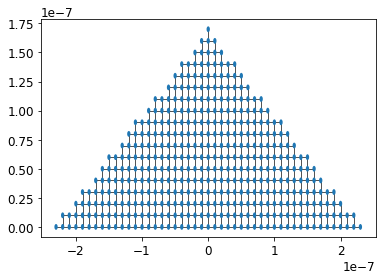

In [392]:
fig, ax = plt.subplots()
kwant.plot(cavity, ax=ax);
#ax.set_ylim(-0.5e-7, 3e-7)

In [393]:
params = tl.finite_coupling_parameters(index=0)

In [567]:
mus_qd = np.linspace(-0.011, 0.01, 300)
key = 'mu_qd'
n = 20
eigen = tl.solver(n=n, key=key)

In [395]:
def wrap(args):
    return eigen(*args)

In [396]:
args = list(it.product([[cavity, f_params]], mus_qd, [params[0]]))
args_db = db.from_sequence(args, npartitions=20)

In [397]:
result = args_db.map(wrap).compute()

In [398]:
ens, wfs = tl.separate_energies_wfs(result)

Text(0, 0.5, '$E_{cavity}$[eV]')

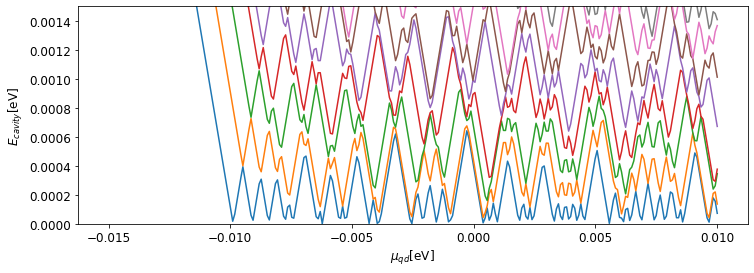

In [399]:
fig, ax = plt.subplots(figsize=(12, 4))
for level in ens.T:
    ax.plot(mus_qd, level)
ax.set_ylim(0, 0.0015)
ax.set_xlabel(r'$\mu_{qd}$[eV]')
ax.set_ylabel(r'$E_{cavity}$[eV]')

In [422]:
def level_spacing(mus, lowest_level, lowest_wfs=None, cavity=None, show_spectra=False, show_wfs=False, ylim=0.001):

    peaks_lowest, _ = find_peaks(x=-np.abs(lowest_level), prominence=1e-12)
    resonances = mus_qd[peaks_lowest]
    energy_resonances = lowest_level[peaks_lowest]

    peaks_first, _ = find_peaks(x=np.abs(lowest_level))
    divisions = mus_qd[peaks_first]
    first_division = np.where(mus==resonances[0]-(divisions[0]-resonances[0]))
    peaks_first = np.hstack([first_division[0], peaks_first])
    divisions = mus_qd[peaks_first]
    energy_divisions = lowest_level[peaks_first]

    intervals = zip(divisions, divisions[1:])

    if show_spectra:
        plt.close()
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(mus_qd, lowest_level)
        ax.scatter(resonances, energy_resonances)
        ax.scatter(divisions, energy_divisions)
        ax.set_ylim(0, ylim)
        ax.set_xlabel(r'$\mu_{qd}$[eV]')
        ax.set_ylabel(r'$E_{cavity}$[eV]')
        plt.savefig('cavity_spectra.svg')
        
    if show_wfs:
        plt.close()
        lowest_wfs = lowest_wfs[peaks_lowest]
        n_wfs = len(lowest_wfs)

        if n_wfs%4 == 0:
            nrows = n_wfs//4
            ncols = 4
        else:
            nrows = n_wfs//4 + 1
            ncols = 4

        density = kwant.operator.Density(cavity, np.eye(4))
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5.5*nrows))
        i = 0
        for ax in axes.flatten():
            kwant.plotter.density(cavity, density(lowest_wfs[i]), ax=ax)
            title = r'$E_{'+str(i)+'}$ = '+str(np.round(energy_resonances[i]*1000, 3))+'[meV]'
            ax.set_title(title)
            ax.set_xlabel(r'$x$[10nm]')
            ax.set_ylabel(r'$y$[10nm]')
            i += 1
            if i == n_wfs-1:
                i -= 1
        plt.savefig('cavity_wavefunctions.svg')
        plt.close()

    return resonances, divisions, intervals

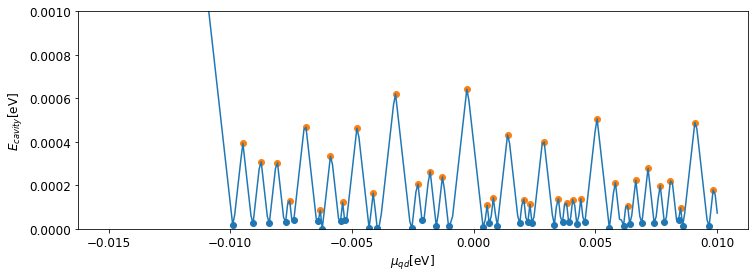

In [405]:
cavity_resonances, _, cavity_intervals = level_spacing(mus=mus_qd,
                                      lowest_level=ens.T[n//2],
                                      show_spectra=True)

## Finite

In [568]:
geometry = {
"A": 400*a**2,
"angle": np.pi/5,
"l": 70*a,
"w": 7*a,
"a": a,
"side": 'up',
"shape": 'triangle'
}

In [569]:
trijunction, f_params = finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


(-5e-08, 3e-07)

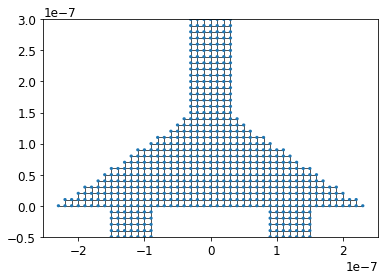

In [570]:
fig, ax = plt.subplots()
kwant.plot(trijunction, ax=ax);
ax.set_ylim(-0.5e-7, 3e-7)

In [571]:
params = tl.finite_coupling_parameters(index=0)

In [572]:
key = 'mu_qd'
n = 6
eigen = tl.solver(n=n, key=key)

In [573]:
def wrap(args):
    return eigen(*args)

In [574]:
args = list(it.product([[trijunction, f_params]], mus_qd, params))
args_db = db.from_sequence(args, npartitions=20)

In [575]:
result = args_db.map(wrap).compute()

distributed.client - WARNING - Couldn't gather 3 keys, rescheduling {"('wrap-20da60c4786e1300576b4e4ad9fc43ac', 11)": ('tls://192.168.4.120:42612',), "('wrap-20da60c4786e1300576b4e4ad9fc43ac', 16)": ('tls://192.168.4.120:39992',), "('wrap-20da60c4786e1300576b4e4ad9fc43ac', 13)": ('tls://192.168.4.120:42612',)}
distributed.client - WARNING - Couldn't gather 8 keys, rescheduling {"('wrap-20da60c4786e1300576b4e4ad9fc43ac', 14)": ('tls://192.168.4.120:45490',), "('wrap-20da60c4786e1300576b4e4ad9fc43ac', 8)": ('tls://192.168.4.120:42166',), "('wrap-20da60c4786e1300576b4e4ad9fc43ac', 2)": ('tls://192.168.4.120:45490',), "('wrap-20da60c4786e1300576b4e4ad9fc43ac', 12)": ('tls://192.168.4.120:42166',), "('wrap-20da60c4786e1300576b4e4ad9fc43ac', 10)": ('tls://192.168.4.120:40142',), "('wrap-20da60c4786e1300576b4e4ad9fc43ac', 5)": ('tls://192.168.3.214:33722',), "('wrap-20da60c4786e1300576b4e4ad9fc43ac', 7)": ('tls://192.168.4.120:45490',), "('wrap-20da60c4786e1300576b4e4ad9fc43ac', 13)": ('tls:/

In [779]:
def average_energy_levels(mus, result):
    averages = []
    centered_mus = []
    widths = []
    ens, _, peaks = tl.coupling_data(result, n=6)

    for k in range(3):
        single_average = []
        single_mus = []
        single_widths = []
        single_peaks = np.hstack([0, peaks[k], -1])
        indices_intervals = zip(single_peaks, single_peaks[1:])
        
        for i, j in indices_intervals:
            energy_section = np.abs(ens[k])[i:j]
            ediff = mus[j]-mus[i]
            average = np.sum(energy_section)/np.abs(ediff)
            single_average.append(average)
            single_mus.append(mus[i])
            single_widths.append(ediff)

        averages.append(np.array(single_average))
        centered_mus.append(np.array(single_mus))
        widths.append(np.array(single_widths))

        min_ws = []
        for w in widths:
            min_ws.append(np.min(w))
        a = min(min_ws)

    return np.array(averages), (np.array(centered_mus)), np.array(widths)

In [784]:
averages, centered_mus, widths = average_energy_levels(mus=mus_qd, result=result)

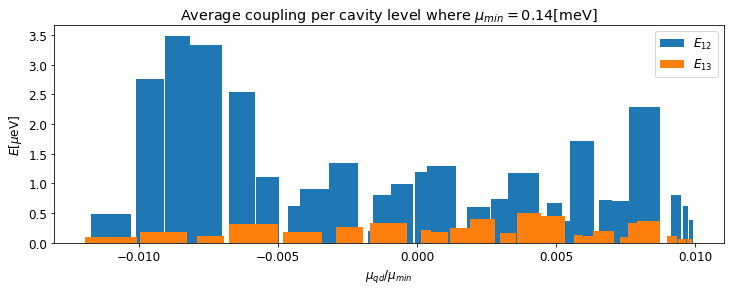

In [786]:
fig, ax = plt.subplots(figsize=(12, 4))
labels = [r'$E_{12}$', r'$E_{13}$', r'$E_{23}$']
for i in range(2):
    ax.bar(centered_mus[i], averages[i], width=widths[i], label=labels[i])
ax.set_title(r'Average coupling per cavity level where $\mu_{min}=$'+str(np.round(a*1000, 3))+'[meV]')
ax.set_ylabel(r'$E[\mu$eV]')
ax.set_xlabel(r'$\mu_{qd}/\mu_{min}$')
ax.legend()

In [733]:
ens, wfs, peaks = tl.coupling_data(result, n=6)

Text(0.5, 0, '$\\mu_{qd}$[meV]')

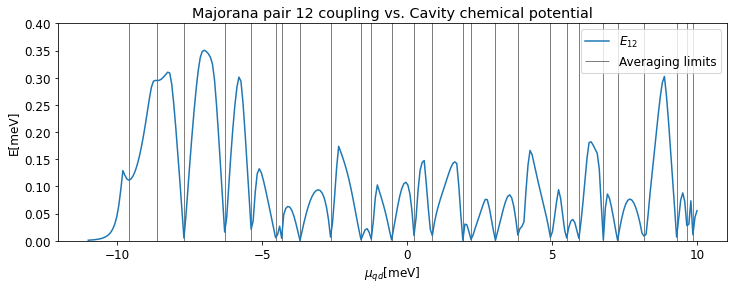

In [774]:
i = 0

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(mus_qd*1000, ens[i]*1000, label=r'$E_{12}$')
ax.vlines(mus_qd[peaks[i]]*1000, ymin=-1, ymax=1, color='black', linewidth=0.5, label='Averaging limits')
#ax.scatter(centered_mus[i], np.array(averages[i])/10000, label='Average coupling')
ax.set_ylim(0, 0.4)
ax.legend(loc='upper right')
ax.set_title(r'Majorana pair 12 coupling vs. Cavity chemical potential')
ax.set_ylabel(r'E[meV]')
ax.set_xlabel(r'$\mu_{qd}$[meV]')

Text(0.5, 0, '$\\mu_{qd}$[meV]')

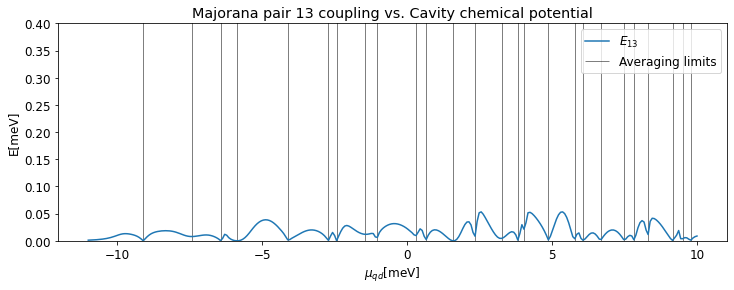

In [735]:
i = 1

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(mus_qd*1000, ens[i]*1000, label=r'$E_{13}$')
ax.vlines(mus_qd[peaks[i]]*1000, ymin=-1, ymax=1, color='black', linewidth=0.5, label='Averaging limits')
#ax.scatter(centered_mus[i], np.array(averages[i])/10000, label='Average coupling')
ax.set_ylim(0, 0.4)
ax.legend(loc='upper right')
ax.set_title(r'Majorana pair 13 coupling vs. Cavity chemical potential')
ax.set_ylabel(r'E[meV]')
ax.set_xlabel(r'$\mu_{qd}$[meV]')